In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
#leemos la informacion censal de poblacion por radio
radios = gpd.read_file('data/informacion_censal_por_radio_2010.shp')
#calculamos la densidad poblaciona l como parametro de interes
radios['densidad'] = radios.TOTAL_POB / (radios.geometry.area / 1000)
#seleccionamos los atributos de interes
radios = radios.reindex(columns=[ 'CO_FRAC_RA', 'COMUNA','TOTAL_POB','densidad','geometry'])
radios.to_file('radios')

In [3]:
#leemos los rios solamente como vector para visualizacion
rios = gpd.read_file('data/rios.shp')
#le asignamos la proyeccion de nuestros radios
rios = rios.to_crs(radios.crs)


In [4]:
from shapely import wkt
#leemos la informacion de parques publicos desde un csv con Well Known Text (WKT)
parques = pd.read_csv('data/espacio-verde-publico.csv')
parques['geometry'] = parques.WKT.apply(wkt.loads)
crs = {'init' :'epsg:4326'}
#a partir del csv y data frame, convertimos en GeoDataFramse con un crs
parques = gpd.GeoDataFrame(parques, geometry='geometry',crs=crs)
parques = parques.reindex(columns= ['nombre','area','geometry'])
parques = parques.to_crs(radios.crs)
parques.to_file('parques')

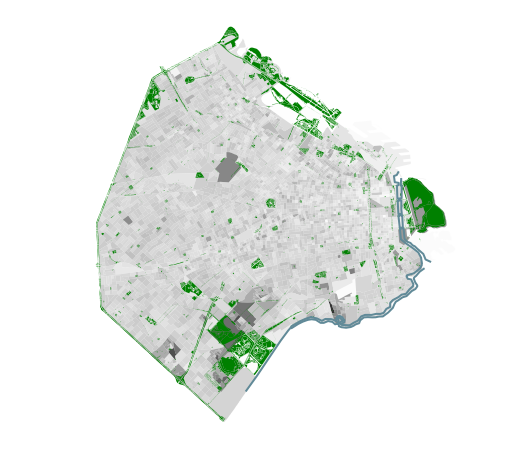

In [5]:
#ploteamos un mapa basico de nuestros datos
f, ax = plt.subplots(1,figsize=(8,8))
radios.plot(column = 'TOTAL_POB',cmap='binary',ax=ax, alpha = 0.8,linewidth=0.1)
rios.plot(ax=ax, color='#618A98',linewidth=2)
parques.plot(ax=ax, color='green')
plt.axis('equal')
ax.set_axis_off()

In [6]:
#f, ax = plt.subplots(1,figsize=(8,8))
#radios.plot(column = 'TOTAL_POB',cmap='binary',ax=ax, alpha = 0.8),markersize = radios.TOTAL_POB/100)
#rios.plot(ax=ax, color='#618A98',linewidth=2)
#parques.plot(ax=ax, color='darkgreen',markersize = parques.loc[:,'area']/2000)
#plt.axis('equal')
#ax.set_axis_off()
#plt.show()

In [7]:
#ciertos procesos geograficos se realizan sobre puntos, no sobre poligonos
#creamos geodataframes con geometrias tipo punto a partir de los centroides

radios_p = radios.copy()
radios_p.geometry = radios_p.geometry.centroid

parques_p = parques.copy() 
parques_p.geometry = parques_p.geometry.centroid

In [8]:
#importamos el objeto geografico multipoint
from shapely.geometry import MultiPoint
#impotamos la operacion geografica que permite ver los puntos mas cercanos
from shapely.ops import nearest_points

#generamos un objeto MultiPoint que contenga todos los puntos-centroides de parques
parques_multi = MultiPoint([i for i in parques_p.geometry])

def distancia_mas_cercano(geom,parques = parques_multi):
    par = nearest_points(geom,parques)
    return par[0].distance(par[1])


In [9]:
#creamos la columna distancia en ambos datasets
radios['distancia'] = radios_p.geometry.map(distancia_mas_cercano)
radios_p['distancia'] = radios_p.geometry.map(distancia_mas_cercano)

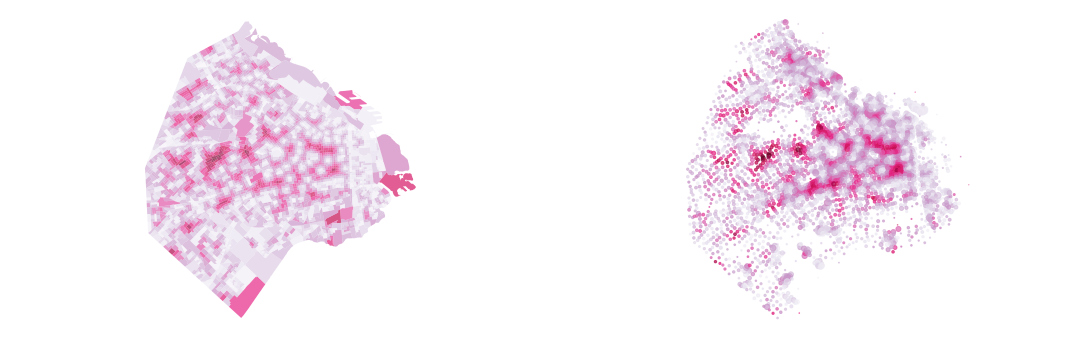

In [10]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(1,2,1) 
ax2 = fig.add_subplot(1,2,2)

radios.plot(column = 'distancia',cmap='PuRd',ax=ax1, alpha = 0.7)
radios_p.plot(column = 'distancia',cmap='PuRd',ax=ax2, alpha = 0.7,markersize = radios.densidad**0.8)
ax1.axis('equal')
ax2.axis('equal')

ax1.set_axis_off()
ax2.set_axis_off()

In [11]:
#import mplleaflet

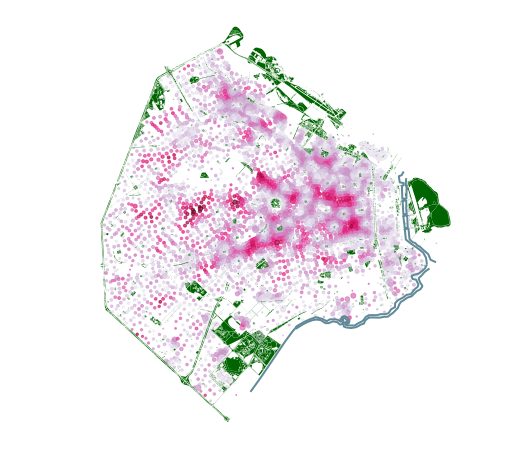

In [12]:
f, ax = plt.subplots(1,figsize=(8,8))
radios_p.plot(column = 'distancia',cmap='PuRd',ax=ax, alpha = 0.7,markersize = radios_p.densidad**0.8)
rios.plot(ax=ax, color='#618A98',linewidth=2)
parques.plot(ax=ax, color='darkgreen',markersize = parques.loc[:,'area']/2000)
plt.axis('equal')
ax.set_axis_off()
f.savefig('mapa_densidad_distancia.png')

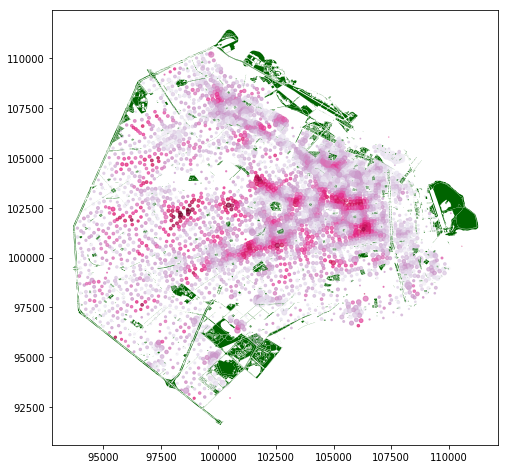

In [13]:
f, ax = plt.subplots(1,figsize=(8,8))
radios_p.plot(column = 'distancia',cmap='PuRd',ax=ax, alpha = 0.7,markersize = radios_p.densidad**0.8)
parques.plot(ax=ax, color='darkgreen',markersize = parques.loc[:,'area']/2000)
#mplleaflet.show(fig=ax.figure, crs=radios.crs, tiles='cartodb_positron', path='puntos_distancia_pob.html')
plt.show()

In [14]:
def pob_a_distancia(minutos,radios=radios_p):
    #velocidad de caminata 5km/h
    metros = minutos*5/60*1000
    radios['metros'] = radios.distancia <= metros
    tabla = radios.loc[:,['metros','TOTAL_POB']].groupby('metros').sum()
    return round(tabla['TOTAL_POB'][True] / tabla['TOTAL_POB'].sum()* 100)

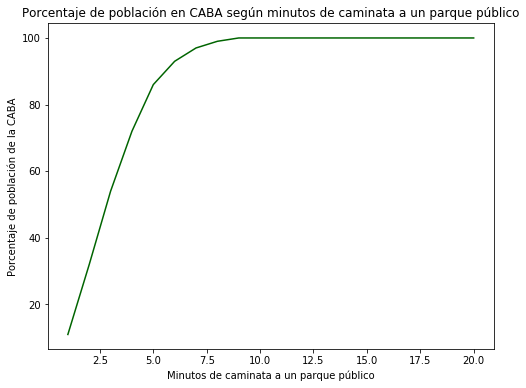

In [15]:
minutos = range(1,21)
prop = [pob_a_distancia(minuto) for minuto in minutos]
f, ax = plt.subplots(1,figsize=(8,6))

ax.plot(minutos,prop,'darkgreen')
ax.set_title('Porcentaje de población en CABA según minutos de caminata a un parque público')
ax.set_xlabel('Minutos de caminata a un parque público')
ax.set_ylabel('Porcentaje de población de la CABA')
f.savefig('porcentajeXminutos.png')

In [16]:
def pob_a_distancia_area(area, minutos = 5,radios=radios_p):
    
    parques_multi = MultiPoint([i for i in parques_p.loc[parques_p.loc[:,'area'] > area,'geometry']])
    
    def distancia_mas_cercano(geom,parques = parques_multi):
        par = nearest_points(geom,parques)
        return par[0].distance(par[1])

    radios['distancia'] = radios.geometry.map(distancia_mas_cercano)
    #velocidad de caminata 5km/h
    metros = minutos*5/60*1000
    radios['metros'] = radios.distancia <= metros
    tabla = radios.loc[:,['metros','TOTAL_POB']].groupby('metros').sum()
    return round(tabla['TOTAL_POB'][True] / tabla['TOTAL_POB'].sum()* 100)

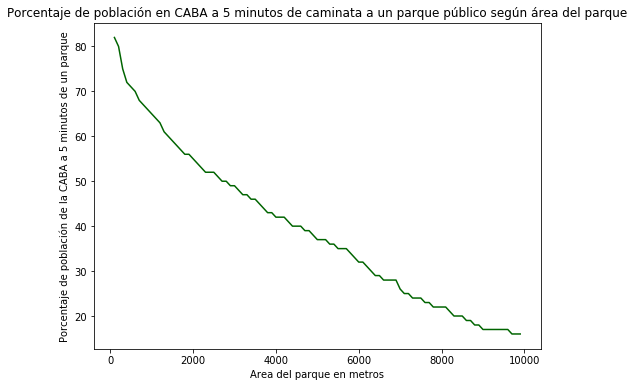

In [17]:
areas = range(100,10000,100)
prop = [pob_a_distancia_area(area) for area in areas]

f, ax = plt.subplots(1,figsize=(8,6))

ax.plot(areas,prop,'darkgreen')
ax.set_title('Porcentaje de población en CABA a 5 minutos de caminata a un parque público según área del parque')
ax.set_xlabel('Area del parque en metros')
ax.set_ylabel('Porcentaje de población de la CABA a 5 minutos de un parque')
f.savefig('porcentajeXarea.png')

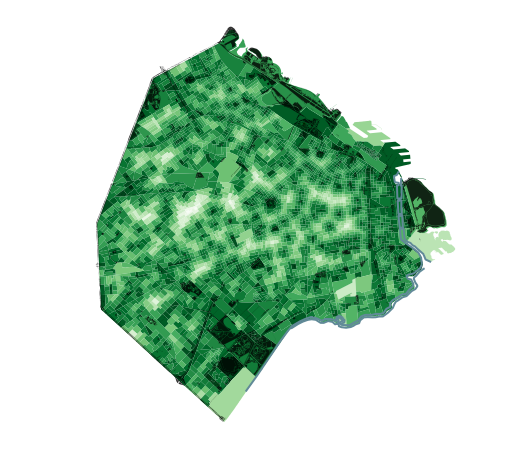

In [18]:
f, ax = plt.subplots(1,figsize=(8,8))
radios.plot(column='distancia',cmap='Greens_r', ax=ax)
parques.plot(color='black',alpha=0.8,ax=ax)
rios.plot(ax=ax, color='#618A98',linewidth=2)
plt.axis('equal')
ax.set_axis_off()
plt.show()
f.savefig('mapa_distancia_en_minutos.png')

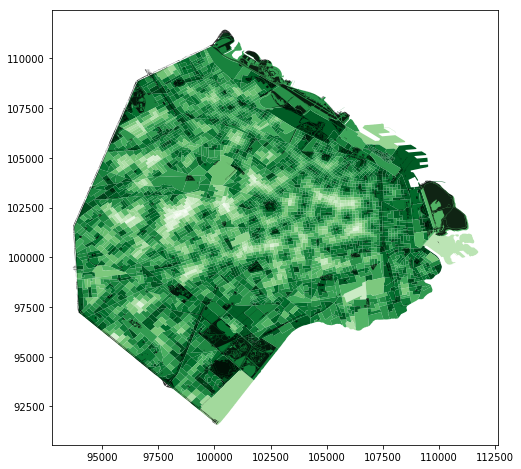

In [19]:
f, ax = plt.subplots(1,figsize=(8,8))
radios.plot(column='distancia',cmap='Greens_r', ax=ax)
parques.plot(color='black',alpha=0.8,ax=ax)


In [20]:
#mplleaflet.show(fig=ax.figure, crs=radios.crs, tiles='cartodb_positron', path='mapa_radios.html')


# Cambio de unidades espaciales

Con los darios censales podemos generar medidas resumen para cada comuna. Pero si queremos utilizar otras unidades espaciales como por ejemplo barrios, debemos saber a que barrio pertenece cada radio.

In [21]:
barrios = gpd.read_file('data/barrios_badata.shp')
barrios.crs

{'proj': 'tmerc',
 'lat_0': -34.6297166,
 'lon_0': -58.4627,
 'k': 0.999998,
 'x_0': 100000,
 'y_0': 100000,
 'ellps': 'intl',
 'units': 'm',
 'no_defs': True}

In [22]:
radios.crs

{'proj': 'tmerc',
 'lat_0': -34.6297166,
 'lon_0': -58.4627,
 'k': 0.999998,
 'x_0': 100000,
 'y_0': 100000,
 'ellps': 'intl',
 'units': 'm',
 'no_defs': True,
 'wktext': True}

In [23]:
radios.crs == barrios.crs

False

In [24]:
barrios = barrios.to_crs(radios.crs)
radios.crs == barrios.crs

True

In [25]:
#spatial join entre poligonos y puntos
radios_p = gpd.sjoin(radios_p,barrios,how="left", op='intersects')
radios_p.head()

,CO_FRAC_RA,COMUNA_left,TOTAL_POB,densidad,geometry,distancia,metros,index_right,BARRIO,COMUNA_right,PERIMETRO,AREA
0,1_1_1,1,336,0.186758,POINT (108665.3126871182 104720.8207945851),759.458804,False,45.0,RETIRO,1.0,18081.948920,4.534476e+06
1,1_12_1,1,341,18.366922,POINT (107109.0640228005 102734.4695358257),476.681857,False,42.0,SAN NICOLAS,1.0,6548.084741,2.289008e+06
2,1_12_10,1,296,6.669166,POINT (107875.0085104886 102710.8695731455),801.930774,False,42.0,SAN NICOLAS,1.0,6548.084741,2.289008e+06
3,1_12_11,1,528,1.441183,POINT (108355.2722380606 102659.5386219609),370.996349,True,42.0,SAN NICOLAS,1.0,6548.084741,2.289008e+06
4,1_12_2,1,229,12.469853,POINT (107239.1886721585 102744.3643416138),469.584909,False,42.0,SAN NICOLAS,1.0,6548.084741,2.289008e+06


In [26]:
#SIGUE DANDO MAL
radios_p.BARRIO.isnull().sum()

3

In [27]:
#vemos los que no tienen barrio
radios_p.loc[radios_p.BARRIO.isnull(),]

,CO_FRAC_RA,COMUNA_left,TOTAL_POB,densidad,geometry,distancia,metros,index_right,BARRIO,COMUNA_right,PERIMETRO,AREA
12,1_13_1,1,586,1.560475,POINT (108956.9855416423 103071.7194696267),258.319596,True,NaN,NaN,NaN,NaN,NaN
13,1_13_4,1,725,2.325532,POINT (108994.0919134651 102347.9451855469),294.174380,True,NaN,NaN,NaN,NaN,NaN
14,1_13_13,1,358,1.612141,POINT (109025.9820823869 101554.9136324561),458.800557,False,NaN,NaN,NaN,NaN,NaN


In [32]:
#un poco de limpieza para leer mejor
radios_p = radios_p.reindex(columns = ['CO_FRAC_RA', 'COMUNA_left', 'TOTAL_POB', 'densidad', 'geometry',
       'distancia', 'BARRIO'])
radios_p.columns =  ['CO_FRAC_RA', 'COMUNA', 'TOTAL_POB', 'densidad', 'geometry',
       'distancia', 'BARRIO']
radios_p.head()

,CO_FRAC_RA,COMUNA,TOTAL_POB,densidad,geometry,distancia,BARRIO
0,1_1_1,1,336,0.186758,POINT (108665.3126871182 104720.8207945851),759.458804,RETIRO
1,1_12_1,1,341,18.366922,POINT (107109.0640228005 102734.4695358257),476.681857,SAN NICOLAS
2,1_12_10,1,296,6.669166,POINT (107875.0085104886 102710.8695731455),801.930774,SAN NICOLAS
3,1_12_11,1,528,1.441183,POINT (108355.2722380606 102659.5386219609),370.996349,SAN NICOLAS
4,1_12_2,1,229,12.469853,POINT (107239.1886721585 102744.3643416138),469.584909,SAN NICOLAS


In [33]:
#lleno los nan para visualizar
radios_p.BARRIO = radios_p.BARRIO.fillna('vacio')

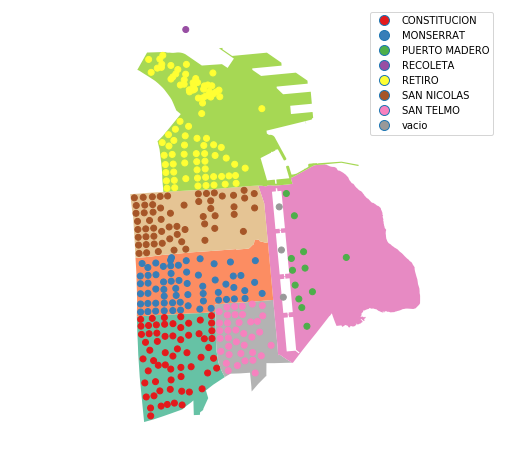

In [35]:
#ploteo comuna 1 para ver que puede estar pasando
f, ax = plt.subplots(1,figsize=(8,8))
barrios.loc[barrios.COMUNA == 1,:].plot(ax=ax,column='BARRIO',cmap='Set2', legend = True)
radios_p.loc[radios_p.COMUNA == 1,:].plot(ax=ax,column='BARRIO',cmap='Set1', legend = True)
plt.axis('equal')
ax.set_axis_off()

In [36]:
radios_p.BARRIO = radios_p.BARRIO.replace({'vacio':'PUERTO MADERO'})

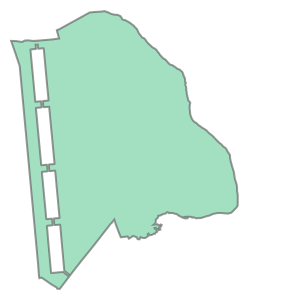

In [49]:
barrios.loc[barrios.BARRIO == 'PUERTO MADERO','geometry'].item()

In [42]:
list(barrios.loc[barrios.BARRIO == 'PUERTO MADERO','geometry'].item().interiors)

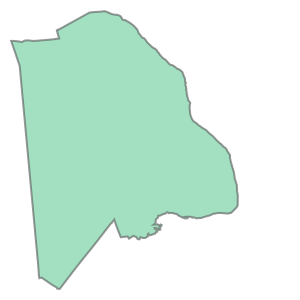

In [48]:
from shapely.geometry import Polygon
pol = barrios.loc[barrios.BARRIO == 'PUERTO MADERO','geometry'].copy().item()
pol = Polygon(pol.exterior.coords)
pol

In [50]:
radios_p.head()

,CO_FRAC_RA,COMUNA,TOTAL_POB,densidad,geometry,distancia,BARRIO
0,1_1_1,1,336,0.186758,POINT (108665.3126871182 104720.8207945851),759.458804,RETIRO
1,1_12_1,1,341,18.366922,POINT (107109.0640228005 102734.4695358257),476.681857,SAN NICOLAS
2,1_12_10,1,296,6.669166,POINT (107875.0085104886 102710.8695731455),801.930774,SAN NICOLAS
3,1_12_11,1,528,1.441183,POINT (108355.2722380606 102659.5386219609),370.996349,SAN NICOLAS
4,1_12_2,1,229,12.469853,POINT (107239.1886721585 102744.3643416138),469.584909,SAN NICOLAS


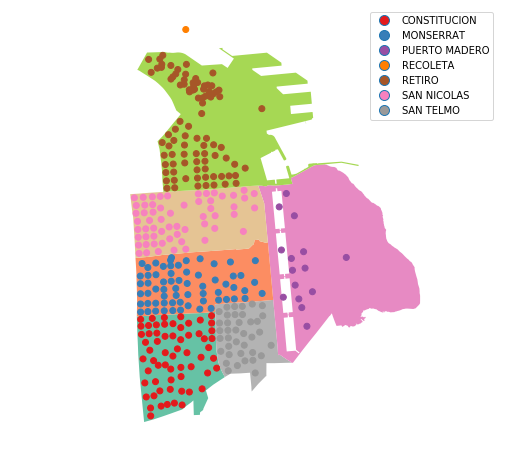

In [51]:
f, ax = plt.subplots(1,figsize=(8,8))
barrios.loc[barrios.COMUNA == 1,:].plot(ax=ax,column='BARRIO',cmap='Set2', legend = True)
radios_p.loc[radios_p.COMUNA == 1,:].plot(ax=ax,column='BARRIO',cmap='Set1', legend = True)
plt.axis('equal')
ax.set_axis_off()

## Obtener estadisticos

In [52]:
radios.head()

,CO_FRAC_RA,COMUNA,TOTAL_POB,densidad,geometry,distancia
0,1_1_1,1,336,0.186758,"POLYGON ((108330.8437499999 104181.0937500013,...",63.263528
1,1_12_1,1,341,18.366922,"POLYGON ((107042.4609375 102801.421875, 107058...",270.076753
2,1_12_10,1,296,6.669166,"POLYGON ((107697.2187500009 102707.15625, 1078...",113.538798
3,1_12_11,1,528,1.441183,"POLYGON ((108748.546875 102668.9453125009, 108...",143.505608
4,1_12_2,1,229,12.469853,"POLYGON ((107169.9375 102810.3671875, 107300.3...",164.186968


In [53]:
#obtenemos un promedio simple
promedio_simple = radios_p.loc[:,['BARRIO','distancia']].groupby('BARRIO').mean().reset_index()
promedio_simple.head()

,BARRIO,distancia
0,AGRONOMIA,1436.217422
1,ALMAGRO,1342.583110
2,BALVANERA,1634.664085
3,BARRACAS,792.171107
4,BELGRANO,755.925187


In [54]:
#pasamos estos datos a la cartografia
promedio_simple = barrios.merge(promedio_simple,on='BARRIO')
promedio_simple = promedio_simple.sort_values(by='distancia')
promedio_simple.head()

,BARRIO,COMUNA,PERIMETRO,AREA,geometry,distancia
40,PUERTO MADERO,1.0,17782.044105,5.027425e+06,"POLYGON ((109722.0190000001 103786.431599999, ...",257.665251
35,VILLA SOLDATI,8.0,12534.571860,8.663595e+06,"POLYGON ((101298.8283999998 97570.93369999982,...",403.185161
11,CONSTITUCION,1.0,6326.844783,2.102009e+06,"POLYGON ((107763.9316000008 99858.67740000194,...",428.874873
30,PARQUE AVELLANEDA,9.0,10165.627129,4.732708e+06,"POLYGON ((99351.29889999985 98944.2235999999, ...",476.382908
16,PARQUE PATRICIOS,4.0,7878.468115,3.743507e+06,"POLYGON ((104852.4884 97887.35280000081, 10469...",495.245091


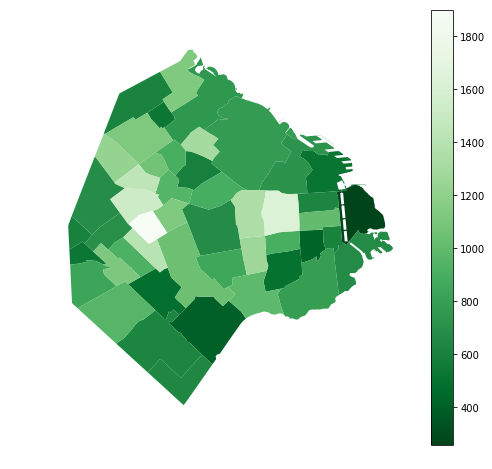

In [55]:
f, ax = plt.subplots(1,figsize=(8,8))
promedio_simple.plot(column='distancia',cmap='Greens_r',ax=ax,legend=True)
plt.axis('equal')
ax.set_axis_off()

In [56]:
def promedio_ponder(dt):
    return np.average(dt.distancia, weights=dt.TOTAL_POB)

In [57]:
#obtenemos un promedio ponderado

promedio_poderado = radios_p.loc[:,['BARRIO','TOTAL_POB','distancia']].groupby('BARRIO').agg(promedio_ponder)
promedio_poderado = promedio_poderado.drop('TOTAL_POB',axis=1)
promedio_poderado = promedio_poderado.sort_values(by='distancia')
promedio_poderado.head()

,distancia
BARRIO,
PUERTO MADERO,291.703280
CONSTITUCION,425.369783
VILLA SOLDATI,447.709162
PARQUE AVELLANEDA,468.527261
PARQUE PATRICIOS,486.202887


In [58]:
dt = pd.DataFrame({'BARRIO':['A','A','B','B'],
                  'distancia':[0,2,10,20],
                   'TOTAL_POB':[0,2,100,2]})

In [59]:
dt.groupby('BARRIO').agg(np.mean)

,distancia,TOTAL_POB
BARRIO,,
A,1,1
B,15,51


In [60]:
dt.groupby('BARRIO').agg(promedio_ponder)

,distancia,TOTAL_POB
BARRIO,,
A,2.000000,2.000000
B,10.196078,10.196078


In [61]:
#pasamos estos datos a la cartografia
promedio_poderado = barrios.merge(promedio_poderado,on='BARRIO')
promedio_poderado = promedio_poderado.sort_values(by='distancia')
promedio_poderado.head()

,BARRIO,COMUNA,PERIMETRO,AREA,geometry,distancia
40,PUERTO MADERO,1.0,17782.044105,5.027425e+06,"POLYGON ((109722.0190000001 103786.431599999, ...",291.703280
11,CONSTITUCION,1.0,6326.844783,2.102009e+06,"POLYGON ((107763.9316000008 99858.67740000194,...",425.369783
35,VILLA SOLDATI,8.0,12534.571860,8.663595e+06,"POLYGON ((101298.8283999998 97570.93369999982,...",447.709162
30,PARQUE AVELLANEDA,9.0,10165.627129,4.732708e+06,"POLYGON ((99351.29889999985 98944.2235999999, ...",468.527261
16,PARQUE PATRICIOS,4.0,7878.468115,3.743507e+06,"POLYGON ((104852.4884 97887.35280000081, 10469...",486.202887


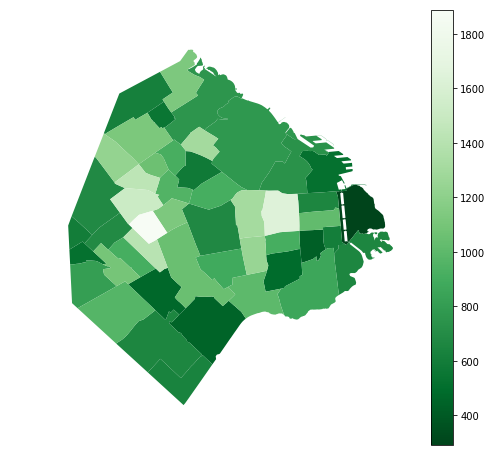

In [62]:
f, ax = plt.subplots(1,figsize=(8,8))
promedio_poderado.plot(column='distancia',cmap='Greens_r',ax=ax,legend=True)
plt.axis('equal')
ax.set_axis_off()